In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn

In [2]:
# --- IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn for Preprocessing and Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Sklearn for Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Sklearn for Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility (Assignment requirement)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Libraries imported successfully!")

Libraries imported successfully!


In [4]:
# --- LOAD DATA ---
# Ensure 'employee_data.csv' is in the same folder as this notebook
df = pd.read_csv('employee_data.csv')

print(f"Original Data Shape: {df.shape}")

# --- DATA CLEANING STEP 1: REMOVE INVALID ROWS ---
# 'Future Start' employees haven't started, so they can't be analyzed for attrition yet.
df = df[df['EmployeeStatus'] != 'Future Start'].copy()

# --- STEP 2: DEFINE TARGET VARIABLE ---
# Logic: If 'Terminated' (Voluntary or Cause) -> 1, Else (Active/Leave) -> 0
target_mapping = {
    'Active': 0,
    'Leave of Absence': 0,
    'Voluntarily Terminated': 1,
    'Terminated for Cause': 1
}

df['Attrition_Flag'] = df['EmployeeStatus'].map(target_mapping)

print(f"Cleaned Data Shape: {df.shape}")
print("\nTarget Variable Distribution:")
print(df['Attrition_Flag'].value_counts(normalize=True))

# Check for missing values
print("\nMissing Values per Column:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Original Data Shape: (3000, 26)
Cleaned Data Shape: (2931, 27)

Target Variable Distribution:
Attrition_Flag
0    0.867963
1    0.132037
Name: proportion, dtype: float64

Missing Values per Column:
ExitDate                  1467
TerminationDescription    1467
dtype: int64


In [6]:
# --- FEATURE ENGINEERING ---

# 1. Convert Dates to DateTime
df['StartDate'] = pd.to_datetime(df['StartDate'], format='%d-%b-%y', errors='coerce')
df['ExitDate'] = pd.to_datetime(df['ExitDate'], format='%d-%b-%y', errors='coerce')

# 2. Calculate 'Tenure_Months'
# If they left, Tenure = ExitDate - StartDate
# If they are active, Tenure = Today (Simulation Date) - StartDate
# We use the max date in the dataset as "Today" to simulate the snapshot time
snapshot_date = df['StartDate'].max()

def calculate_tenure(row):
    if pd.notnull(row['ExitDate']):
        return (row['ExitDate'] - row['StartDate']).days / 30
    else:
        return (snapshot_date - row['StartDate']).days / 30

df['Tenure_Months'] = df.apply(calculate_tenure, axis=1)

# Handle negative tenure (data errors) by clipping to 0
df['Tenure_Months'] = df['Tenure_Months'].clip(lower=0)

# 3. Drop Columns
# - ID/Names/Email: Not predictive (Unique identifiers)
# - ExitDate/TerminationType: DATA LEAKAGE! (These directly tell us the answer)
# - EmployeeStatus: This is what we derived the target from
cols_to_drop = [
    'EmpID', 'FirstName', 'LastName', 'ADEmail', 'Supervisor', # Identifiers
    'ExitDate', 'TerminationType', 'TerminationDescription',   # Leakage
    'EmployeeStatus', 'Title',                                 # Redundant/High Cardinality
    'DOB', 'Description', 'Training Dates'                     # If they exist
]

# Drop only columns that actually exist in the dataframe
cols_to_drop = [c for c in cols_to_drop if c in df.columns]
df_model = df.drop(columns=cols_to_drop)

print("Feature Engineering Complete.")
print(f"Final features for modeling: {df_model.shape[1]}")
df_model.head()

Feature Engineering Complete.
Final features for modeling: 17


,StartDate,BusinessUnit,EmployeeType,PayZone,EmployeeClassificationType,DepartmentType,Division,State,JobFunctionDescription,GenderCode,LocationCode,RaceDesc,MaritalDesc,Performance Score,Current Employee Rating,Attrition_Flag,Tenure_Months
0,2019-09-20,CCDR,Contract,Zone C,Temporary,Production,Finance & Accounting,MA,Accounting,Female,34904,White,Widowed,Fully Meets,4,0,47.200000
1,2023-02-11,EW,Contract,Zone A,Part-Time,Production,Aerial,MA,Labor,Male,6593,Hispanic,Widowed,Fully Meets,3,0,5.866667
2,2018-12-10,PL,Full-Time,Zone B,Part-Time,Sales,General - Sga,MA,Assistant,Male,2330,Hispanic,Widowed,Fully Meets,4,0,56.666667
3,2021-06-21,CCDR,Contract,Zone A,Full-Time,Sales,Finance & Accounting,ND,Clerk,Male,58782,Other,Single,Fully Meets,2,0,25.866667
4,2019-06-29,TNS,Contract,Zone A,Temporary,Sales,General - Con,FL,Laborer,Female,33174,Other,Married,Fully Meets,3,0,49.966667


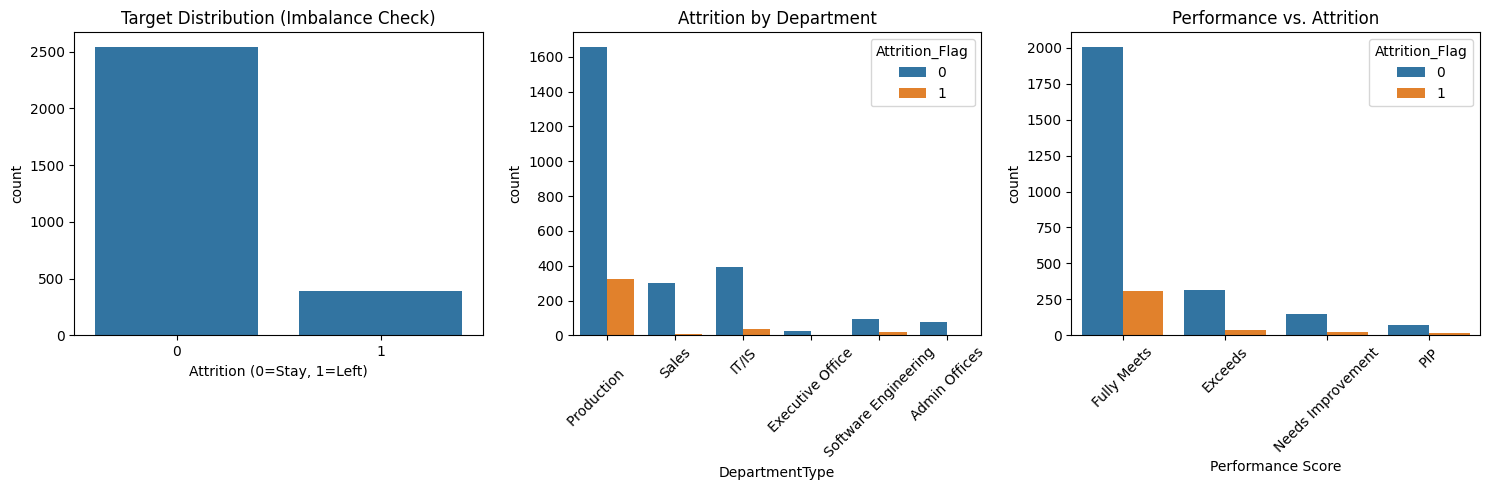

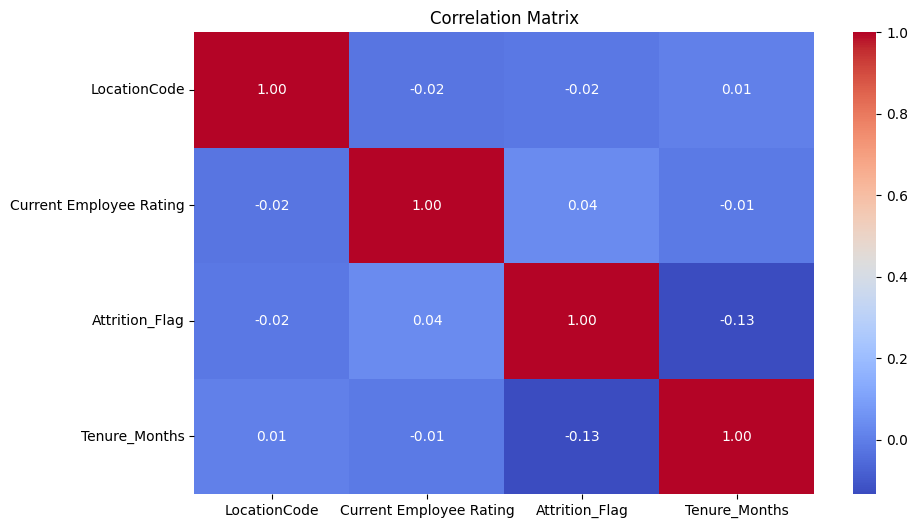

In [7]:
# --- EDA VISUALIZATIONS ---
plt.figure(figsize=(15, 5))

# Plot 1: Attrition Count
plt.subplot(1, 3, 1)
sns.countplot(x='Attrition_Flag', data=df)
plt.title('Target Distribution (Imbalance Check)')
plt.xlabel('Attrition (0=Stay, 1=Left)')

# Plot 2: Attrition by Department
plt.subplot(1, 3, 2)
sns.countplot(x='DepartmentType', hue='Attrition_Flag', data=df)
plt.title('Attrition by Department')
plt.xticks(rotation=45)

# Plot 3: Performance Score vs Attrition
plt.subplot(1, 3, 3)
sns.countplot(x='Performance Score', hue='Attrition_Flag', data=df)
plt.title('Performance vs. Attrition')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('eda_plots.png') # Save for report
plt.show()

# Statistical Correlation (Numeric only)
plt.figure(figsize=(10, 6))
numeric_df = df_model.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [8]:
# --- PREPROCESSING ---

# Define X (Features) and y (Target)
X = df_model.drop('Attrition_Flag', axis=1)
y = df_model['Attrition_Flag']

# Identify Column Types
numeric_features = ['Current Employee Rating', 'Tenure_Months', 'LocationCode']
categorical_features = [col for col in X.columns if col not in numeric_features]

print(f"Numeric Features: {numeric_features}")
print(f"Categorical Features: {categorical_features}")

# Create Transformers
# 1. Numeric: Scale data (StandardScaler)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Categorical: One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# --- TRAIN-TEST SPLIT ---
# Using Stratify=y because our dataset is imbalanced (more people stay than leave)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

print(f"Training Data: {X_train.shape}")
print(f"Test Data: {X_test.shape}")

Numeric Features: ['Current Employee Rating', 'Tenure_Months', 'LocationCode']
Categorical Features: ['StartDate', 'BusinessUnit', 'EmployeeType', 'PayZone', 'EmployeeClassificationType', 'DepartmentType', 'Division', 'State', 'JobFunctionDescription', 'GenderCode', 'RaceDesc', 'MaritalDesc', 'Performance Score']
Training Data: (2344, 16)
Test Data: (587, 16)


In [9]:
# --- MODEL DEFINITION ---

# Dictionary of models to test
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_SEED),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_SEED)
}

# Results dictionary to store metrics
results = {}

# --- TRAINING LOOP ---
for name, model in models.items():
    # Create a full pipeline: Preprocessor -> Model
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    
    # Train the model
    print(f"Training {name}...")
    clf.fit(X_train, y_train)
    
    # Predict
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None
    
    # Calculate Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else 0
    
    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': roc_auc,
        'Model': clf # Save trained model for later
    }
    
    # Print quick summary
    print(f"  --> Recall: {recall:.4f} | AUC: {roc_auc:.4f}\n")

print("Training Complete!")

Training Logistic Regression...
  --> Recall: 0.0256 | AUC: 0.6960

Training Random Forest...
  --> Recall: 0.0000 | AUC: 0.6260

Training Gradient Boosting...
  --> Recall: 0.0128 | AUC: 0.6378

Training Complete!


In [10]:
# --- COMPARISON TABLE ---
results_df = pd.DataFrame(results).T.drop(columns=['Model']) # Drop model object from view
results_df = results_df.sort_values(by='Recall', ascending=False)

print("\n--- MODEL PERFORMANCE LEADERBOARD ---")
display(results_df)

# Justification:
# We sort by RECALL because in Attrition prediction, catching a leaver (True Positive)
# is more important than being right about someone staying.


--- MODEL PERFORMANCE LEADERBOARD ---


,Accuracy,Precision,Recall,F1-Score,AUC
Logistic Regression,0.868825,0.666667,0.025641,0.049383,0.69596
Gradient Boosting,0.867121,0.5,0.012821,0.025,0.637827
Random Forest,0.867121,0.0,0.0,0.0,0.625951


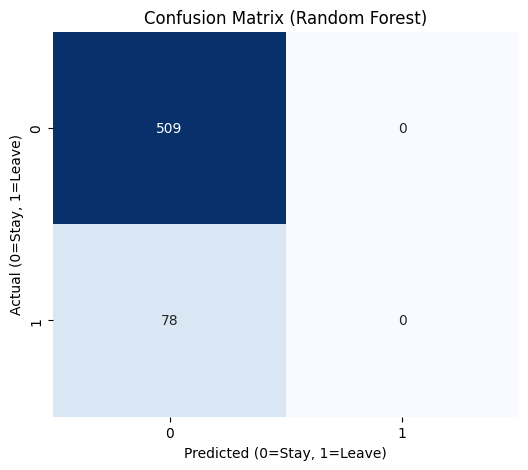

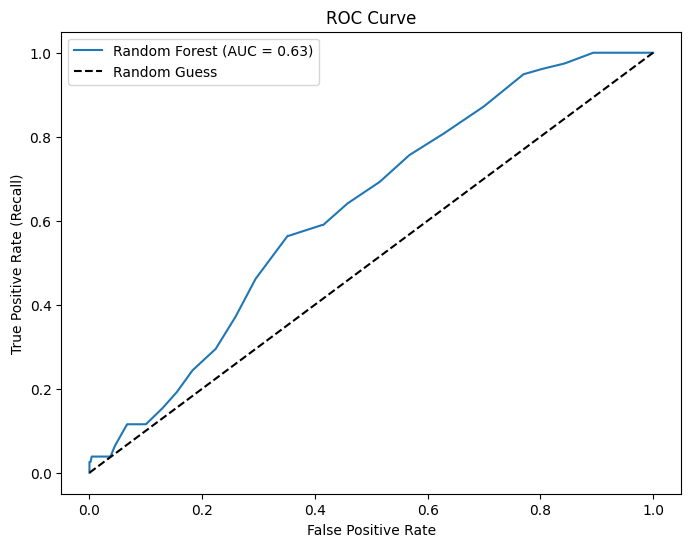

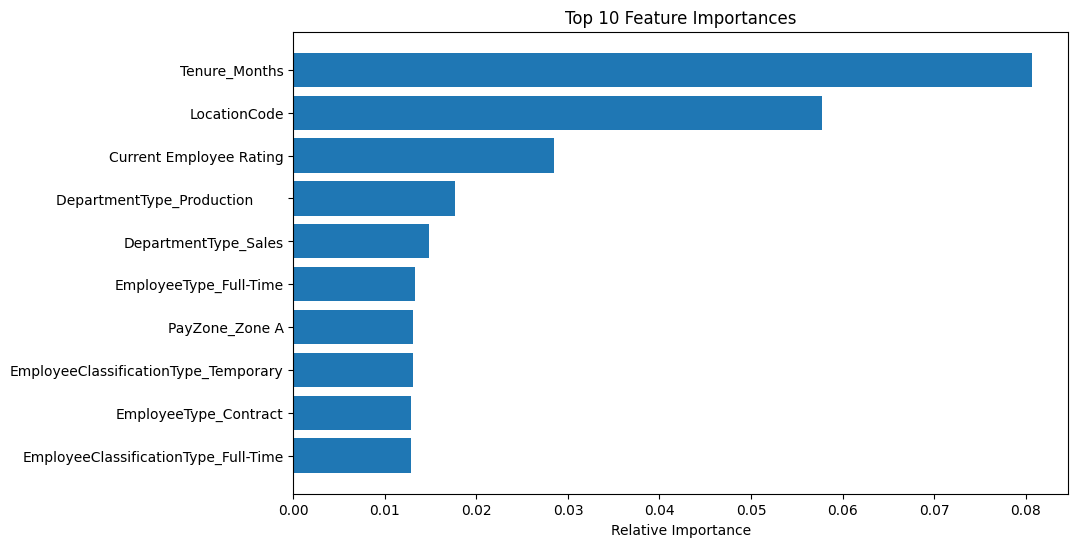

In [11]:
# --- DEEP DIVE: BEST MODEL ---
# Let's pick Random Forest as the primary model for detailed analysis
best_model_name = 'Random Forest' 
best_pipeline = results[best_model_name]['Model']

y_pred = best_pipeline.predict(X_test)
y_prob = best_pipeline.predict_proba(X_test)[:, 1]

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix ({best_model_name})')
plt.xlabel('Predicted (0=Stay, 1=Leave)')
plt.ylabel('Actual (0=Stay, 1=Leave)')
plt.show()

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {results[best_model_name]["AUC"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 3. Feature Importance (Only for Tree-based models)
# We need to access the model inside the pipeline
model_step = best_pipeline.named_steps['classifier']
preprocessor_step = best_pipeline.named_steps['preprocessor']

# Get feature names from one-hot encoder
try:
    cat_features_encoded = preprocessor_step.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)
    all_features = numeric_features + list(cat_features_encoded)
    
    importances = model_step.feature_importances_
    indices = np.argsort(importances)[-10:] # Top 10

    plt.figure(figsize=(10, 6))
    plt.title('Top 10 Feature Importances')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [all_features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
except:
    print("Could not extract feature importance (likely due to pipeline structure).")